<h1>Understanding QSP-Generated Quantum Circuit Scaling</h1>

<h2> Distribution Statement </h2>

DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

<br>
This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

<br>
© 2022 Massachusetts Institute of Technology.

<br>
<br>
The software/firmware is provided to you on an As-Is basis

<br>
<br>
Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.

This notebook examines how the circuits generated by pyQSP scale.


In [6]:
### 
### Publicly Available Libraries:
###
import sys
import os
import time
import cirq
import numpy             as np
import numpy.linalg      as la
import scipy.integrate   as spi
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd


###
### Imports to support the pyQSP Gate-Based simulation
###
from pyLIQTR.QSP import gen_qsp     as qspFuncs
from pyLIQTR.QSP import QSP         as pQSP
from pyLIQTR.QSP.Hamiltonian import Hamiltonian as pyH

from pyLIQTR.QSP.gen_qsp import QSP_Simulator
from pyLIQTR.QSP.qsp_helpers import qsp_decompose_once, print_to_openqasm, count_qubits

import pyLIQTR.model_simulators.vlasovsim as vs        
from pyLIQTR.gate_decomp.cirq_transforms import clifford_plus_t_direct_transform

<h2> Generate Hamiltonians to solve the Vlasov problem of varying sizes </h2>

In [2]:
###
### User Input: Vlasov Equation Parameterization 
###

Ns     =  [4, 8, 16, 32 , 64, 128]             # Number of terms in the Vlasov-Hermite 
                                               # expansion (equivalent to qubits)

k      =  2.0                                  # Fourier wavenumber

nu     =  0.0                                  # Collisional damping parameter : 
                                               # (for use only with statevector propagation)
                                               # (SET TO 0 for now, since imag otherwise)

alpha  =  0.6                                  # Electric field parameter

###
### User Input: QSP Parameterization
###
timestep_of_interest = 0.05
required_precision   = 1e-4



ham_strings = []
qsp_hams    = []
steps       = []
for N_ in Ns:
    curr_hs    = vs.hamiltonian_wfn_vlasov_hermite_linear_sym_string(k, alpha, nu, N_)
    curr_qsp_H = pyH(curr_hs)
    
    qsp_hams.append(curr_qsp_H)
    ham_strings.append(curr_hs)
    steps.append(qspFuncs.get_phis(curr_qsp_H, simtime=timestep_of_interest, req_prec=required_precision, steps_only=True))

Angle generation takes a lot of time. Since we aren't performing the actual circuit simulation, but only looking for a resource assessment, we present the option to generate lists of stand-in angles. 

_Note:_ Generating meaningful angles from scratch produces a lot of stdout and takes approximate times listed below to run

<table>
    <tr>
        <th>Problem Size</th>
        <th>Angles Generated</th>
        <th>Time to Generate Angles (sec)</th>
    </tr>
    <tr>
        <td>4</td>
        <td>9</td>
        <td>~0.5</td>
    </tr>
    <tr>
        <td>8</td>
        <td>13</td>
        <td>~1</td>
    </tr>
    <tr>
        <td>16</td>
        <td>21</td>
        <td>~2</td>
    </tr>
    <tr>
        <td>32</td>
        <td>41</td>
        <td>~3</td>
    </tr>
    <tr>
        <td>64</td>
        <td>41</td>
        <td>~11</td>
    </tr>
    <tr>
        <td>128</td>
        <td>85</td>
        <td>~45</td>
    </tr>
    <tr>
        <td>256</td>
        <td>205</td>
        <td>~460</td>
    </tr>
</table>

In [ ]:
### 
### Toggle boolean for angle generation preferences
###
gen_angles   = True
angles       = []
angles_times = []

if gen_angles:
    
    for qsp_H in qsp_hams:
        
        t_start = time.time()
        tmp     = qspFuncs.get_phis(qsp_H, simtime=timestep_of_interest, req_prec=required_precision)
        t_stop  = time.time()

        angles.append(tmp[0])
        angles_times.append(t_stop-t_start)
        

else:
    for step in steps:
        angles.append(np.arange(0, 1+1/step, 1/step))   

Now generate the circuits

In [4]:
###
### A function to generate the circuit scaling statistics. Left in the notebook
### to enable future customizability.
###

def generate_circuit_stats(ham, angs, csv_out='scaling_data.csv', save_circuit=False):

    t_start_time = time.time()

    # Generate circuit:
    qsp_generator   = pQSP.QSP(phis=angs, hamiltonian=ham, target_size=ham.problem_size)
    curr_circ       = qsp_generator.circuit()
    t_initial_generation_time = time.time()

    # Decompose circuit:
    decomposed_circuit       = cirq.align_left(qsp_decompose_once(qsp_decompose_once(curr_circ)))
    t_decomp_to_toffoli_time = time.time()

    cliffT_decomp_circuit   = cirq.align_left(clifford_plus_t_direct_transform(decomposed_circuit))
    t_decomp_to_cliffT_time = time.time()

    if save_circuit:
        # Save circuit to file in OpenQASM 2.0 format:
        with open(f'open_qasm_for_problem_size_{H.problem_size}_toffoli.qasm', 'w') as f:
            print_to_openqasm(f, decomposed_circuit)
        t_write_toffoli_time = time.time()
        
        with open(f'open_qasm_for_problem_size_{H.problem_size}_cliffT.qasm', 'w') as f:
            print_to_openqasm(f, cliffT_decomp_circuit)
        t_write_cliffT_time = time.time()


    # Lets write all this stuff out:
    if os.path.exists(csv_out):
        yes_header = False
    else:
        yes_header = True
    out_file = open(csv_out, 'a')
    if yes_header:
        out_file.write('Prob_Size,Circ_Gen_Time,Toff_Decomp_Time,CliffT_Decomp_Time,Write_Out_Toff_Time,Write_Out_CliffT_Time,Ttl_Qubits,Anc_Qubits,Ctl_Qubits,Circ_Depth_Toff,Circ_Depth_cliffT\n')

    # Calculate the times
    t_gen    = (t_initial_generation_time - t_start_time)
    t_toff   = (t_decomp_to_toffoli_time  - t_initial_generation_time)
    t_clifft = (t_decomp_to_cliffT_time   - t_decomp_to_toffoli_time)
    if save_circuit:
        t_write_out_toff   = (t_write_toffoli_time - t_decomp_to_cliffT_time)
        t_write_out_cliffT = (t_write_cliffT_time  - t_write_toffoli_time)
    else:
        t_write_out_toff   = -1
        t_write_out_cliffT = -1

    print_string = f'{ham.problem_size},{t_gen},{t_toff},{t_clifft},{t_write_out_toff},{t_write_out_cliffT}'

    ttl_qubits, ctl_qubits, anc_qubits = count_qubits(curr_circ)

    print_string += f',{ttl_qubits},{anc_qubits},{ctl_qubits}'


    depth_toff   = len(cirq.align_left(decomposed_circuit))
    depth_cliffT = len(cirq.align_left(cliffT_decomp_circuit))

    print_string += f',{depth_toff},{depth_cliffT}\n'

    out_file.write(print_string)

In [5]:
for H, angs in zip(qsp_hams, angles):
    
    generate_circuit_stats(H, angs)

data = pd.read_csv('scaling_data.csv')

In [2]:
data = pd.read_csv('../benchmark_data/QSP/Script_Scaling_Data.csv')

Plot some parameters of interest

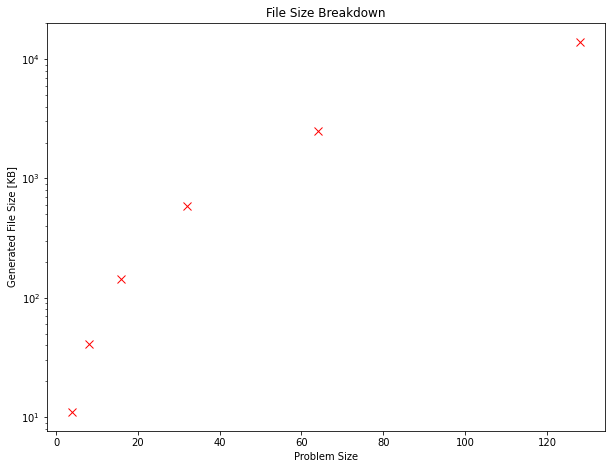

In [13]:
###
### Saved OpenQASM 2.0 File Size
### For Rotation-level Decomposition:
###

file_sizes = [11, 41, 144, 586, 2500, 14000] # KB

plt.figure(figsize=(10,7.5))
plt.plot(prob_size, file_sizes, 'rx', markersize=8)
plt.title('File Size Breakdown')
plt.xlabel('Problem Size')
plt.ylabel('Generated File Size [KB]')
plt.yscale('log')

Text(0, 0.5, 'Time [msec]')

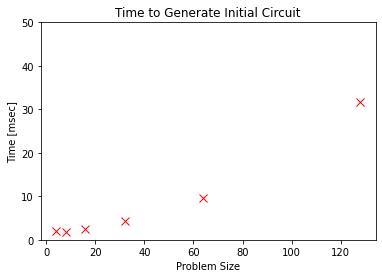

In [3]:
###
### Timing:
###


# plt.figure(figsize=(10/2,7.5/2), dpi=300)

plt.plot(data['Prob_Size'], data['Circ_Gen_Time']*1000, 'rx', markersize=8)
plt.ylim([0, 50])
plt.title('Time to Generate Initial Circuit')
plt.xlabel('Problem Size')
plt.ylabel('Time [msec]')

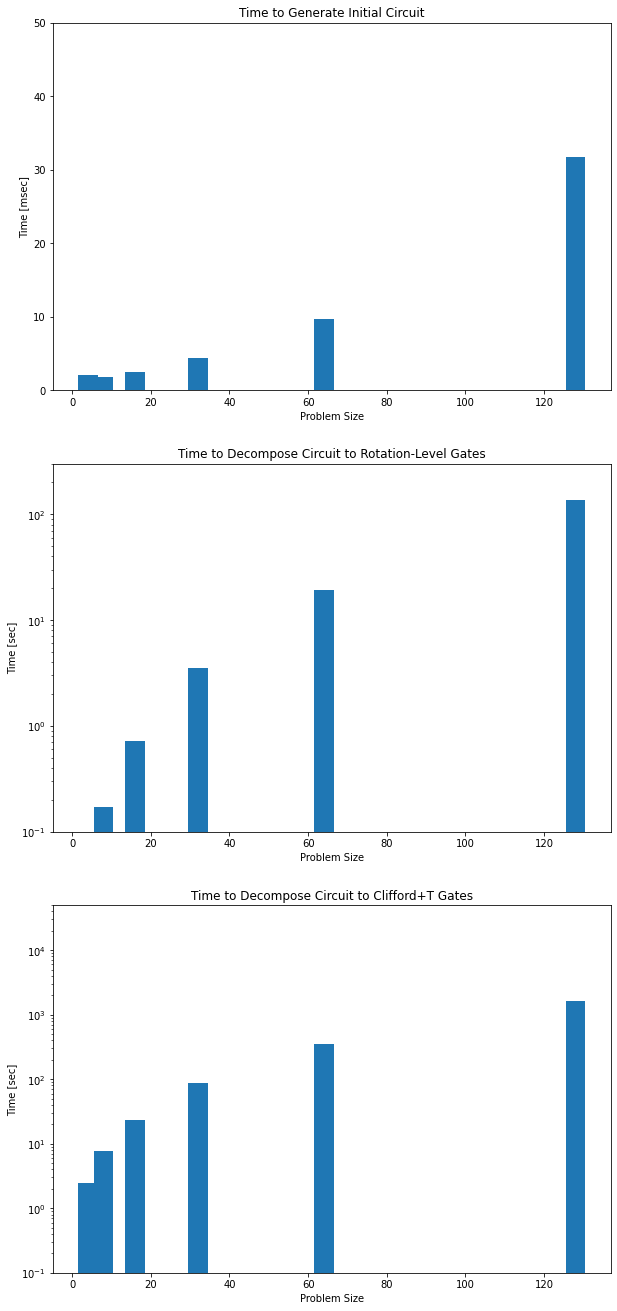

In [29]:
###
### Timing:
###

fig_time, ax_time = plt.subplots(3)
fig_time.set_figheight(23)
fig_time.set_figwidth(10)

ax_time[0].bar(data['Prob_Size'], data['Circ_Gen_Time']*1000, width=5)
ax_time[0].set_ylim([0, 50])
ax_time[0].set_title('Time to Generate Initial Circuit')
ax_time[0].set_xlabel('Problem Size')
ax_time[0].set_ylabel('Time [msec]')

ax_time[1].bar(data['Prob_Size'], data['Toff_Decomp_Time'], width=5)
ax_time[1].set_ylim([0.1, 300])
ax_time[1].set_title('Time to Decompose Circuit to Rotation-Level Gates')
ax_time[1].set_xlabel('Problem Size')
ax_time[1].set_ylabel('Time [sec]')
ax_time[1].set_yscale('log')

ax_time[2].bar(data['Prob_Size'], data['CliffT_Decomp_Time'], width=5)
ax_time[2].set_ylim([0.1, 50000])
ax_time[2].set_title('Time to Decompose Circuit to Clifford+T Gates')
ax_time[2].set_xlabel('Problem Size')
ax_time[2].set_ylabel('Time [sec]')
ax_time[2].set_yscale('log')


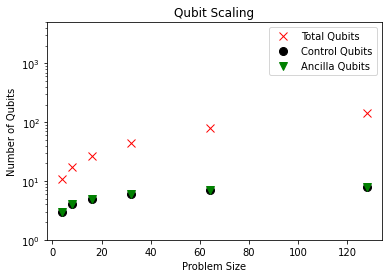

In [4]:
###
### Number of Qubits:
###
# plt.figure(figsize=(10/2,7.5/2), dpi=200)
plt.plot(data['Prob_Size'], data['Ttl_Qubits'], 'rx', markersize=8)
plt.plot(data['Prob_Size'], data['Ctl_Qubits'], 'ko', markersize=8)
plt.plot(data['Prob_Size'], data['Anc_Qubits'], 'gv', markersize=8)
plt.title('Qubit Scaling')
plt.xlabel('Problem Size')
plt.ylim([1, 5000])
plt.ylabel('Number of Qubits')
plt.yscale('log')
plt.legend([
    'Total Qubits',
    'Control Qubits',
    'Ancilla Qubits'
])

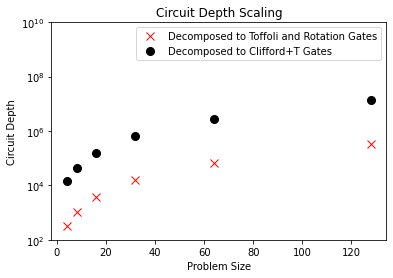

In [5]:
###
### Circuit Depth:
###

# plt.figure(figsize=(10/2,7.5/2), dpi=300)

plt.plot(data['Prob_Size'], data['Circ_Depth_Toff'], 'rx', markersize=8)
plt.plot(data['Prob_Size'], data['Circ_Depth_cliffT'], 'ko', markersize=8)
plt.yscale('log')
plt.ylim([10e1, 10e9])
plt.xlabel('Problem Size')
plt.ylabel('Circuit Depth')
plt.title('Circuit Depth Scaling')

plt.legend([
    'Decomposed to Toffoli and Rotation Gates',
    'Decomposed to Clifford+T Gates',
])